In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
x = torch.tensor([1.0, 2.0])
print(x.numpy())

[1. 2.]


In [5]:
# Start timer
start_time = time.time()

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# device = "cpu"
# Geometry
Lx, Ly, Lz = 0.1, 0.08, 0.01  # meters
nx, ny, nz = 200, 160, 20 # 100, 80, 10
dx = Lx / nx
dy = Ly / ny
dz = Lz / nz

# Material and BCs
k = 1.0       # W/m·K
h = 0.1       # W/m²·K
T_inf = 300.0 # K

# Initialize fields
T = torch.ones((nx, ny, nz), device=device) * T_inf
Q = torch.zeros_like(T)

# Internal heat source of 5W in center 2x2 region
source_cells = 2 * 2 * 1
vol = dx * dy * dz
Q_val = 5.0 / (source_cells * vol)  # W/m³

Q[nx//2-1:nx//2+1, ny//2-1:ny//2+1, :] = Q_val

# Iterative solver
alpha = dx * dy * dz / k
for step in range(5000):
    T_old = T.clone()

    # Internal nodes update
    T[1:-1,1:-1,:] = (
        T_old[2:,1:-1,:] + T_old[:-2,1:-1,:] +
        T_old[1:-1,2:,:] + T_old[1:-1,:-2,:] +
        T_old[1:-1,1:-1,:] * 2 +  # z-direction has no neighbors
        alpha * Q[1:-1,1:-1,:]
    ) / 6.0

    # Convective BC on all boundaries
    conv_coeff = h * dx / k

    # Left boundary (x=0)
    T[0,1:-1,:] = (
        T_old[1,1:-1,:] + T_old[0,2:,:] + T_old[0,:-2,:] + T_old[0,1:-1,:]*2 +
        alpha * Q[0,1:-1,:] + conv_coeff * T_inf
    ) / (5 + conv_coeff)

    # Right boundary (x=nx-1)
    T[-1,1:-1,:] = (
        T_old[-2,1:-1,:] + T_old[-1,2:,:] + T_old[-1,:-2,:] + T_old[-1,1:-1,:]*2 +
        alpha * Q[-1,1:-1,:] + conv_coeff * T_inf
    ) / (5 + conv_coeff)

    # Bottom boundary (y=0)
    T[1:-1,0,:] = (
        T_old[2:,0,:] + T_old[:-2,0,:] + T_old[1:-1,1,:] + T_old[1:-1,0,:]*2 +
        alpha * Q[1:-1,0,:] + conv_coeff * T_inf
    ) / (5 + conv_coeff)

    # Top boundary (y=ny-1)
    T[1:-1,-1,:] = (
        T_old[2:,-1,:] + T_old[:-2,-1,:] + T_old[1:-1,-2,:] + T_old[1:-1,-1,:]*2 +
        alpha * Q[1:-1,-1,:] + conv_coeff * T_inf
    ) / (5 + conv_coeff)

    # Print the step no.
    if step % 500 == 0:
        print(f"Step {step}")

# End timer
end_time = time.time()
print(f"Simulation complete in {end_time - start_time:.3f} seconds")


Using device: cuda
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Step 3000
Step 3500
Step 4000
Step 4500
Simulation complete in 10.809 seconds


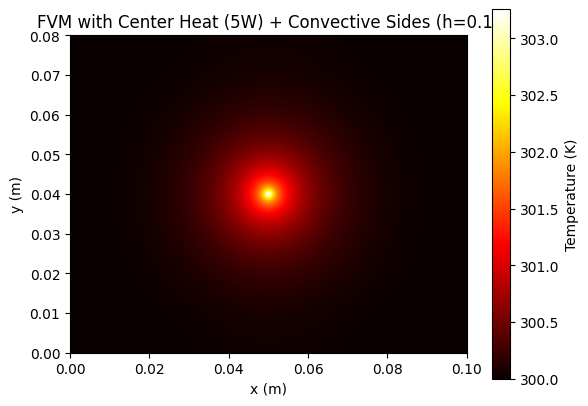

In [4]:
# Plot
T_cpu = T[:,:,0].detach().cpu().numpy()
plt.imshow(T_cpu.T, origin='lower', cmap='hot', extent=[0,Lx,0,Ly])
plt.colorbar(label="Temperature (K)")
plt.title("FVM with Center Heat (5W) + Convective Sides (h=0.1)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()